<a href="https://colab.research.google.com/github/devangi2000/Deep-Learning/blob/master/Lung_Disease_Prediction_vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
! pip install -q kaggle

In [9]:
from google.colab import files

In [10]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"devangipurkayastha","key":"8c1085f287c6d0aa936a69819f785ac3"}'}

In [11]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
 ! chmod 600 ~/.kaggle/kaggle.json

In [14]:
! kaggle datasets list

ref                                                    title                                              size  lastUpdated          downloadCount  
-----------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
anmolkumar/health-insurance-cross-sell-prediction      Health Insurance Cross Sell Prediction 🏠 🏥          6MB  2020-09-11 18:39:31           1565  
shivan118/healthcare-analytics                         Healthcare Analytics                                2MB  2020-09-13 17:40:05            811  
Cornell-University/arxiv                               arXiv Dataset                                     885MB  2020-09-14 16:54:47           2929  
nipunarora8/age-gender-and-ethnicity-face-data-csv     AGE, GENDER AND ETHNICITY (FACE DATA) CSV          63MB  2020-09-02 13:46:38            484  
datatattle/covid-19-nlp-text-classification            Coronavirus tweets NLP - Text Classification       

In [15]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:31<00:00, 121MB/s]
100% 2.29G/2.29G [00:31<00:00, 78.3MB/s]


In [16]:
! mkdir train

mkdir: cannot create directory ‘train’: File exists


In [17]:
! unzip chest-xray-pneumonia.zip -d train

Streaming output truncated to the last 5000 lines.
  inflating: train/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: train/chest_xray/train/NORMAL/IM-0

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Sequential, Model
from glob import glob
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [19]:
# resize all images to (224,224)
img_size = [224,224,3]

train_path = '/train/chest_xray/train'
valid_path = '/train/chest_xray/valid'
test_path = '/train/chest_xray/test'

In [20]:
# first we import the Vgg 16 library, add preprocessing layer to the top of VGG
# we use imagenet weights
# vgg has 1000 categories but we have 2 categories, so we drop last layer and add our own input layer

vgg = VGG16(include_top=False, weights='imagenet', input_shape=img_size)


In [21]:
# avoid training existing weights
for layer in vgg.layers:
  layer.trainable = False

In [22]:
# get number of output classes
num_folders = glob('train/chest_xray/train/*')
num_folders

['train/chest_xray/train/NORMAL', 'train/chest_xray/train/PNEUMONIA']

In [23]:
# my layers - customisable
# I've dropped the first and the last layers
x = Flatten()(vgg.output)

In [24]:
x

<tf.Tensor 'flatten/Reshape:0' shape=(None, 25088) dtype=float32>

In [27]:
# len(num_folders) tells how many categories we have in output layer, and here it is 2
prediction = Dense(len(num_folders), activation='softmax')(x)
prediction

<tf.Tensor 'dense_2/Softmax:0' shape=(None, 2) dtype=float32>

In [28]:
#combine input and output to form a model
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [29]:
#compile the model by specifying the preferred optimizer, loss and metrics
model.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

In [30]:
# these are steps to upload the dataset in Keras
# it also helps create additional data for training process
# for test dataset, no need to create additional data

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip=True,
    vertical_flip = True,
    rescale=1./255
)
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [32]:
# Insert some images using flow_from_directory

training_set = train_datagen.flow_from_directory('train/chest_xray/chest_xray/train',
                                                 target_size= (224,224),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 shuffle='True')

Found 5216 images belonging to 2 classes.


In [33]:
testing_set = train_datagen.flow_from_directory('train/chest_xray/chest_xray/test',
                                                 target_size= (224,224),
                                                 batch_size=32,
                                                 class_mode='categorical',
                                                 )

Found 624 images belonging to 2 classes.


In [34]:
# fit the model
history = model.fit_generator(training_set,
                              steps_per_epoch=len(training_set),
                              epochs=5,
                              validation_data=testing_set,
                              validation_steps=len(testing_set),
                              )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
163/163 [==============================] - 2986s 18s/step - loss: 0.2777 - accuracy: 0.8957 - val_loss: 0.4633 - val_accuracy: 0.8237
Epoch 2/5
163/163 [==============================] - 2982s 18s/step - loss: 0.1410 - accuracy: 0.9486 - val_loss: 0.5235 - val_accuracy: 0.8269
Epoch 3/5
163/163 [==============================] - 2981s 18s/step - loss: 0.1147 - accuracy: 0.9569 - val_loss: 0.6308 - val_accuracy: 0.7917
Epoch 4/5
163/163 [==============================] - 2974s 18s/step - loss: 0.1020 - accuracy: 0.9601 - val_loss: 0.4369 - val_accuracy: 0.8654
Epoch 5/5
163/163 [==============================] - 2974s 18s/step - loss: 0.1047 - accuracy: 0.9617 - val_loss: 0.7424 - val_accuracy: 0.7949


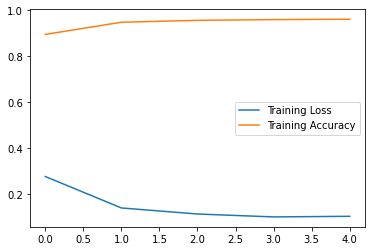

<Figure size 432x288 with 0 Axes>

In [35]:
# Plotting

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()
plt.savefig('Training')

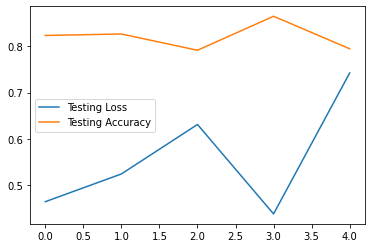

<Figure size 432x288 with 0 Axes>

In [36]:
# Plotting

plt.plot(history.history['val_loss'], label='Testing Loss')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.legend()
plt.show()
plt.savefig('Testing')

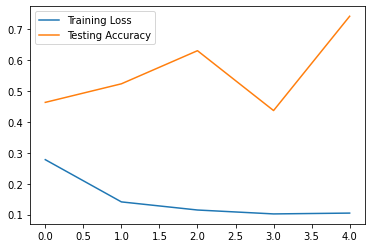

<Figure size 432x288 with 0 Axes>

In [37]:
# Plotting

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Accuracy')
plt.legend()
plt.show()
plt.savefig('Loss')

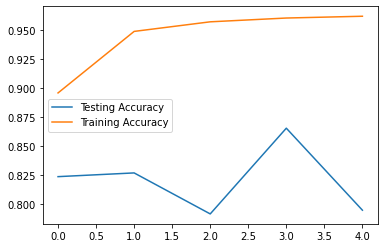

<Figure size 432x288 with 0 Axes>

In [38]:
# Plotting

plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.show()
plt.savefig('Accuracy')

In [39]:
#save the model

import tensorflow as tf
from keras.models import load_model

model.save('vgg16.h5')

In [ ]:
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# HERE'S THE CODE TO ACTUALLY TEST THE MODEL

# from keras.models import load_model
# from keras.preprocessing import image
# from keras.applications.vgg16 import preprocess_input

model = load_model('vgg16.h5')
img = image.load('val/chest_xray/chest_xray/test/person1946_bacteria.4874.jpg', target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img_data = preprocess_input(x)
classes = model.predict(img_data)